In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
data = pd.read_csv("weather_data.csv", sep = ";")
data[:]

,time,month,temperature,feelslike,wind,direction,gust,cloud,humidity,precipitation,pressure,weather
0,0:00,1,24.0,28.0,8.0,ENE,12.0,4.0,86.0,0.0,1012.0,Clear
1,3:00,1,23.0,27.0,8.0,NE,10.0,4.0,88.0,0.0,1011.0,Clear
2,6:00,1,23.0,26.0,8.0,NNE,11.0,7.0,85.0,0.0,1012.0,Sunny
3,9:00,1,28.0,33.0,11.0,NNE,13.0,6.0,64.0,0.0,1012.0,Sunny
4,12:00,1,31.0,35.0,10.0,ENE,12.0,62.0,53.0,0.0,1010.0,Partly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...
8507,9:00,11,29.0,32.0,4.0,ENE,5.0,17.0,68.0,0.0,1012.0,Partly cloudy
8508,12:00,11,33.0,37.0,5.0,ENE,5.0,15.0,52.0,0.0,1011.0,Partly cloudy
8509,15:00,11,34.0,38.0,3.0,ENE,4.0,19.0,50.0,0.0,1009.0,Partly cloudy
8510,18:00,11,31.0,34.0,6.0,SE,8.0,19.0,65.0,0.0,1009.0,Partly cloudy


time              object
month              int64
temperature      float64
feelslike        float64
wind             float64
direction         object
gust             float64
cloud            float64
humidity         float64
precipitation    float64
pressure         float64
weather           object
dtype: object


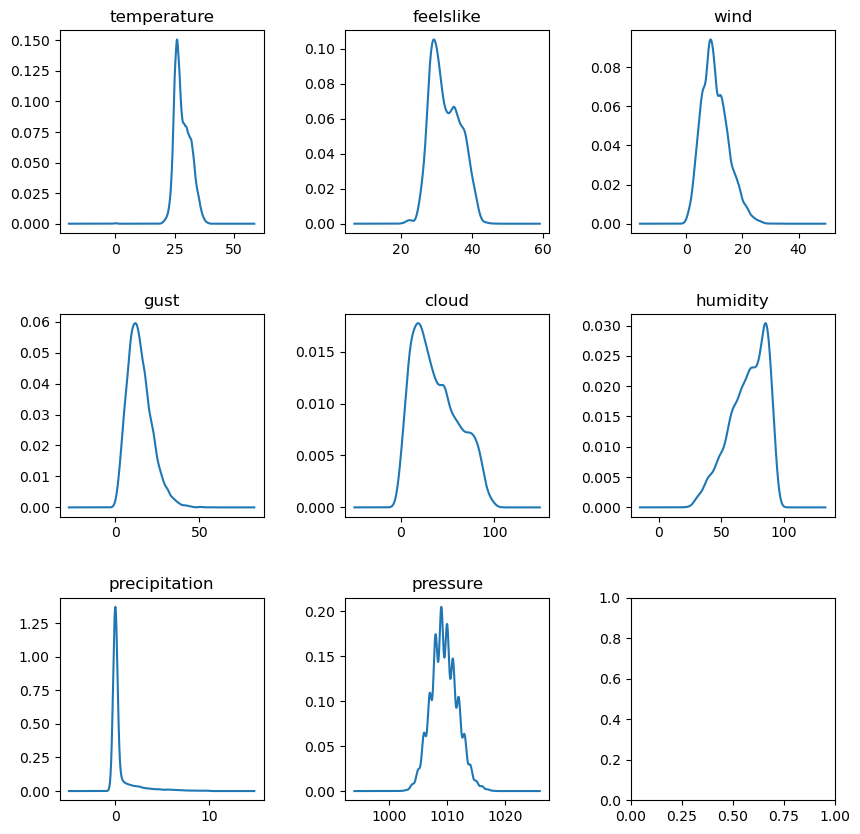

In [206]:
print(data.dtypes)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

num_attr = ['temperature', 'feelslike', 'wind', 'gust', 'cloud', 'humidity', 'precipitation', 'pressure']
for i in  range(len(num_attr)):
    a = num_attr[i]
    data[a].plot(ax=axs[i//3,i%3],kind='kde', xlabel=a)
    axs[i//3,i%3].set_title(a)
    axs[i//3,i%3].set_ylabel("")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [207]:
data["target"] = data.shift(-1)["weather"]
data[:]
print(data['direction'].unique())

['ENE' 'NE' 'NNE' 'ESE' 'E' 'SE' 'SSE' 'NNW' 'WSW' 'S' 'WNW' 'NW' 'W' 'SW'
 'SSW' 'N']


In [208]:
data = data.drop("weather", axis=1)
data = data.drop("precipitation", axis=1)    # Too many values 0 that leads to overfitting

# Change from 16 directions to 8 directions
data['direction'] = data['direction'].replace(['ENE', 'NE', 'NNE'], 'NE')
data['direction'] = data['direction'].replace(['ESE', 'SE', 'SSE'], 'SE')
data['direction'] = data['direction'].replace(['NNW', 'NW', 'WNW'], 'NW')
data['direction'] = data['direction'].replace(['WSW', 'SW', 'SSW'], 'SW')

# Change from time to 2 sessions a day
data['time'] = data['time'].replace(['0:00', '3:00', '6:00', '9:00'], 'earlier')
data['time'] = data['time'].replace(['12:00', '15:00', '18:00', '21:00'], 'later')

# Change from month to seasons
data['month'] = data['month'].replace([1, 2, 3], 'spring')
data['month'] = data['month'].replace([4, 5, 6], 'summer')
data['month'] = data['month'].replace([7, 8, 9], 'autumn')
data['month'] = data['month'].replace([10, 11, 12], 'winter')

In [209]:
data.drop(8511, inplace=True)

In [210]:
data = data.rename(columns={'month': 'season'})

In [211]:
# Transform the label to rain possiblity label
label_map = {
    'Heavy rain at times': 'Heavy/moderate rain',
    'Heavy rain': 'Heavy/moderate rain',
    'Moderate rain at times':'Heavy/moderate rain',
    'Moderate rain':'Heavy/moderate rain',
    'Mist': 'Mist/drizzle',
    'Light drizzle': 'Mist/drizzle',
    'Light rain': 'Light rain',
    'Patchy light drizzle': 'Mist/drizzle',
    'Patchy light rain with thunder': 'Light rain',
    'Patchy light rain': 'Light rain',
    'Torrential rain shower': 'Heavy/moderate rain',
    'Thundery outbreaks possible': 'Cloudy',
    'Overcast': 'Heavy/moderate rain',
    'Light rain shower': 'Light rain',
    'Cloudy': 'Cloudy',
    'Moderate or heavy rain shower': 'Heavy/moderate rain',
    'Patchy rain possible': 'Light rain',
    'Sunny': 'Sunny',
    'Clear': 'Clear',
    'Partly cloudy': 'Cloudy',
}

data['target'] = data['target'].map(label_map)
print(data['target'].value_counts())
y = data['target']

Cloudy                 4294
Light rain             1179
Clear                  1102
Sunny                  1003
Heavy/moderate rain     864
Mist/drizzle             69
Name: target, dtype: int64


In [212]:
data = data.rename(columns={'month': 'season'})
x = data[['time', 'season', 'temperature', 'feelslike', 'wind', 'direction',
       'gust', 'cloud', 'humidity', 'pressure']].values


In [213]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import *

num_orders = [2,3,4,6,7,8,9]
cat_orders = [0,1,5]


In [214]:
# Pipeline for categorical data handling
cat_pl= Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),    # Handle missing values with mean value though in this dataset we don't have
           ('onehot', OneHotEncoder(handle_unknown= 'ignore'))]     # Transform categorical data into onehot vectors
        ) 

# Pipeline for numerical data handling
num_pl = Pipeline(
    steps=[
           ('imputer', SimpleImputer(strategy='mean')),             # Handle missing values with forward value though in this dataset we don't have
           ('mmscaler', MinMaxScaler())]                            # Normalization with MinMaxScaling
         )

In [215]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
                                        ('num', num_pl, num_orders),    # apply cat_pl for categorical columns
                                        ('cat', cat_pl, cat_orders)]    # apply num_pl for numerical columns
               )

In [216]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
o_spl = SMOTE()
x_encode = preprocessor.fit_transform(x)
x_balanced, y_balanced = o_spl.fit_resample(x_encode, y)
print(x.shape, y.shape)
print(y_balanced.value_counts())

(8511, 10) (8511,)
Clear                  4294
Sunny                  4294
Cloudy                 4294
Light rain             4294
Heavy/moderate rain    4294
Mist/drizzle           4294
Name: target, dtype: int64


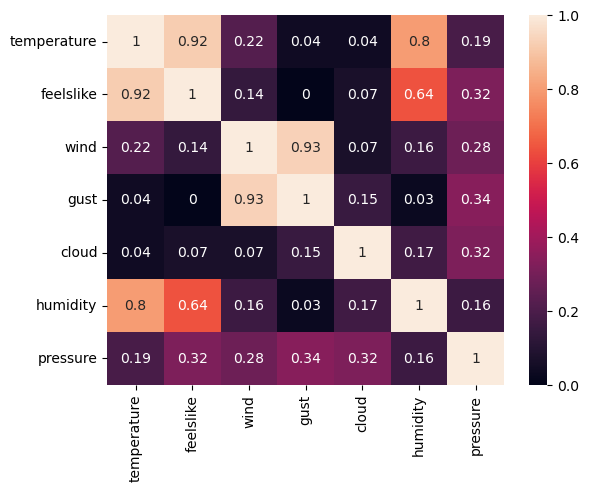

In [224]:
matrix = data.corr(numeric_only=True).abs().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [218]:
le = LabelEncoder()
le.fit(['Cloudy', 'Light rain', 'Clear', 'Sunny', 'Heavy/moderate rain', 'Mist/drizzle'])
y_balanced = le.transform(y_balanced) 

In [219]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size = 0.2, stratify = y_balanced, random_state = 1)

Accuracy on train: 1.00


TEST SCORE
Accuracy score: 0.88
Recall score: 0.88
Precision score: 0.87
F1 score: 0.87


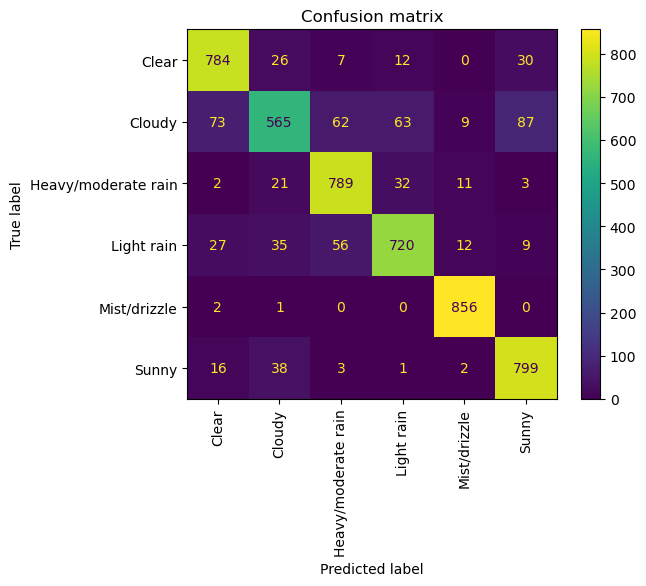

In [223]:
# Completed training pipeline
clf = RandomForestClassifier()

# training
clf.fit(x_train, y_train)

# accuracy
y_train_validate = clf.predict(x_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_validate)):.2f}")

y_pred = clf.predict(x_test)
print('\n\nTEST SCORE')
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.2f}')
print(f'Recall score: {recall_score(y_test, y_pred, average="macro"):.2f}')
print(f'Precision score: {precision_score(y_test, y_pred, average="macro"):.2f}')
print(f'F1 score: {f1_score(y_test, y_pred, average="macro"):.2f}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()
plt.xticks(rotation = 90)
plt.title('Confusion matrix')
plt.show()